In [469]:
import numpy as np
import numpy.polynomial as P
import scipy as sp
from matplotlib import pyplot as plt
from tqdm import tqdm
#from sklearn.preprocessing import PolynomialFeatures
from multiprocessing import Pool
import multiprocessing
import ZVnbrosse
from sklearn.preprocessing import PolynomialFeatures
from potentials import GaussPotential,GaussMixture,GausMixtureIdent,GausMixtureSame,BananaShape
from samplers import MCMC_sampler,Generate_train,ULA_light
from baselines import set_function,construct_ESVM_kernel,GenerateSigma
from martingale import approx_q
from optimize import Run_eval_test,optimize_parallel_new 
from utils import * 
import copy

In [470]:
def H(k, x):
    if k==0:
        return 1.0
    if k ==1:
        return x
    if k==2:
        return (x**2 - 1)/np.sqrt(2)
    c = np.zeros(k+1,dtype = float)
    c[k] = 1.0
    h = P.hermite_e.hermeval(x,c) / np.sqrt(sp.special.factorial(k)) 
    return h

def compute_H(k,x):
    return H(k[0],x[:,0])*H(k[1],x[:,1])

In [471]:
def test_traj(coefs_poly_regr,gamma,r_seed,lag,d,cov,N_test,x0):
    """
    function to perform 1-dimensional martingale decomposition
    """
    X_test,Noise = generate_traj(x0,N_test,gamma,r_seed,d,cov)
    test_stat_vanilla = np.zeros(N_test,dtype = float)
    test_stat_vr = np.zeros_like(test_stat_vanilla)
    #compute number of basis polynomials
    basis_funcs = np.array([[1,0],[0,1],[1,1],[2,0],[0,2]])
    num_basis_funcs = len(basis_funcs)
    #compute polynomials of noise variables Z_l
    poly_vals = np.zeros((num_basis_funcs,N_test), dtype = float)
    for k in range(len(basis_funcs)):
        poly_vals[k,:] = compute_H(basis_funcs[k],Noise)
    #initialize function
    f_vals_vanilla = np.sum(np.sin(X_test),axis=1)
    #array to store control variates values
    cvfs = np.zeros_like(f_vals_vanilla)
    #compute coeffitients bar_a
    bar_a_0_1 = np.zeros((lag,N_test),dtype=float)
    bar_a_1_0 = np.zeros_like(bar_a_0_1)
    bar_a_1_1 = np.zeros_like(bar_a_0_1)
    bar_a_2_0 = np.zeros_like(bar_a_0_1)
    bar_a_0_2 = np.zeros_like(bar_a_0_1)
    for i in range(lag):
        #coefficients with H_0_1
        bar_a_0_1[i,1:] = coefs_poly_regr[i,1]*cov[0,1]*np.sqrt(gamma)*sigma(X_test[:-1])[:,0]+\
                        coefs_poly_regr[i,2]*cov[1,1]*np.sqrt(gamma)*sigma(X_test[:-1])[:,1]+\
                        2*coefs_poly_regr[i,3]*cov[0,1]*np.sqrt(gamma)*sigma(X_test[:-1])[:,0]*(X_test[:-1]+gamma*b(X_test[:-1]))[:,0]+\
                        coefs_poly_regr[i,4]*(((X_test[:-1]+gamma*b(X_test[:-1]))[:,0])*sigma(X_test[:-1])[:,1]*np.sqrt(gamma)*cov[1,1] +\
                                             ((X_test[:-1]+gamma*b(X_test[:-1]))[:,1])*sigma(X_test[:-1])[:,0]*np.sqrt(gamma)*cov[0,1])+\
                        2*coefs_poly_regr[i,5]*cov[1,1]*np.sqrt(gamma)*sigma(X_test[:-1])[:,1]*(X_test[:-1]+gamma*b(X_test[:-1]))[:,1]
        bar_a_0_1[i,0] = coefs_poly_regr[i,1]*cov[0,1]*np.sqrt(gamma)*sigma(x0)[0]+\
                        coefs_poly_regr[i,2]*cov[1,1]*np.sqrt(gamma)*sigma(x0)[1]+\
                        2*coefs_poly_regr[i,3]*cov[0,1]*np.sqrt(gamma)*sigma(x0)[0]*(x0+gamma*b(x0))[0]+\
                        coefs_poly_regr[i,4]*(((x0+gamma*b(x0))[0])*sigma(x0)[1]*np.sqrt(gamma)*cov[1,1] +\
                                             ((x0+gamma*b(x0))[1])*sigma(x0)[0]*np.sqrt(gamma)*cov[0,1])+\
                        2*coefs_poly_regr[i,5]*cov[1,1]*np.sqrt(gamma)*sigma(x0)[1]*(x0+gamma*b(x0))[1]
        #coefficients with H_1_0
        bar_a_1_0[i,1:] = coefs_poly_regr[i,1]*cov[0,0]*np.sqrt(gamma)*sigma(X_test[:-1])[:,0]+\
                        coefs_poly_regr[i,2]*cov[0,1]*np.sqrt(gamma)*sigma(X_test[:-1])[:,1]+\
                        2*coefs_poly_regr[i,3]*cov[0,0]*np.sqrt(gamma)*sigma(X_test[:-1])[:,0]*(X_test[:-1]+gamma*b(X_test[:-1]))[:,0]+\
                        coefs_poly_regr[i,4]*(((X_test[:-1]+gamma*b(X_test[:-1]))[:,0])*sigma(X_test[:-1])[:,1]*np.sqrt(gamma)*cov[0,1] +\
                                             ((X_test[:-1]+gamma*b(X_test[:-1]))[:,1])*sigma(X_test[:-1])[:,0]*np.sqrt(gamma)*cov[0,0])+\
                        2*coefs_poly_regr[i,5]*cov[0,1]*np.sqrt(gamma)*sigma(X_test[:-1])[:,1]*(X_test[:-1]+gamma*b(X_test[:-1]))[:,1]
        bar_a_1_0[i,0] = coefs_poly_regr[i,1]*cov[0,0]*np.sqrt(gamma)*sigma(x0)[0]+\
                        coefs_poly_regr[i,2]*cov[0,1]*np.sqrt(gamma)*sigma(x0)[1]+\
                        2*coefs_poly_regr[i,3]*cov[0,0]*np.sqrt(gamma)*sigma(x0)[0]*(x0+gamma*b(x0))[0]+\
                        coefs_poly_regr[i,4]*(((x0+gamma*b(x0))[0])*sigma(x0)[1]*np.sqrt(gamma)*cov[0,1] +\
                                             ((x0+gamma*b(x0))[1])*sigma(x0)[0]*np.sqrt(gamma)*cov[0,0]) +\
                        2*coefs_poly_regr[i,5]*cov[0,1]*np.sqrt(gamma)*sigma(x0)[1]*(x0+gamma*b(x0))[1]
        #second-order coefficients
        bar_a_1_1[i,1:] = coefs_poly_regr[i,4]*gamma#+\
                        #2*coefs_poly_regr[i,7]*gamma*(X_test[:-1]+gamma*b(X_test[:-1]))[:,0] +\
                        #*coefs_poly_regr[i,8]*gamma*(X_test[:-1]+gamma*b(X_test[:-1]))[:,1] 
        bar_a_1_1[i,0] = coefs_poly_regr[i,4]*gamma#+\
                        #2*coefs_poly_regr[i,7]*gamma*(x0+gamma*b(x0))[0] +\
                        #2*coefs_poly_regr[i,8]*gamma*(x0+gamma*b(x0))[1] 
        #coefficients with H_2_0
        bar_a_2_0[i,1:] = np.sqrt(2)*coefs_poly_regr[i,3]*gamma #+\
                        #3*np.sqrt(2)*coefs_poly_regr[i,6]*gamma*(X_test[:-1]+gamma*b(X_test[:-1]))[:,0] +\
                        #np.sqrt(2)*coefs_poly_regr[i,7]*gamma*(X_test[:-1]+gamma*b(X_test[:-1]))[:,1]
        bar_a_2_0[i,0] = np.sqrt(2)*coefs_poly_regr[i,3]*gamma #+\
                        #3*np.sqrt(2)*coefs_poly_regr[i,6]*gamma*(x0+gamma*b(x0))[0] +\
                        #np.sqrt(2)*coefs_poly_regr[i,7]*gamma*(x0+gamma*b(x0))[1]
        #coefficients with H_0_2
        bar_a_0_2[i,1:] = np.sqrt(2)*coefs_poly_regr[i,5]*gamma #+\
                        #3*np.sqrt(2)*coefs_poly_regr[i,9]*gamma*(X_test[:-1]+gamma*b(X_test[:-1]))[:,0] +\
                        #np.sqrt(2)*coefs_poly_regr[i,8]*gamma*(X_test[:-1]+gamma*b(X_test[:-1]))[:,1]
        bar_a_0_2[i,0] = np.sqrt(2)*coefs_poly_regr[i,5]*gamma #+\
                        #3*np.sqrt(2)*coefs_poly_regr[i,9]*gamma*(x0+gamma*b(x0))[0] +\
                        #np.sqrt(2)*coefs_poly_regr[i,8]*gamma*(x0+gamma*b(x0))[1]
    bar_a_1_0 = bar_a_1_0*poly_vals[0,:]
    bar_a_0_1 = bar_a_0_1*poly_vals[1,:]
    bar_a_1_1 = bar_a_1_1*poly_vals[2,:]
    bar_a_2_0 = bar_a_2_0*poly_vals[3,:]
    bar_a_0_2 = bar_a_0_2*poly_vals[4,:]
    #compute martingale sums
    M_n_0_1 = 0.0
    M_n_1_0 = 0.0
    M_n_1_1 = 0.0
    M_n_2_0 = 0.0
    M_n_0_2 = 0.0
    for l in range(N_test):
        for r in range(min(N_test-l,lag)):
            M_n_0_1 += bar_a_0_1[r,l]
            M_n_1_0 += bar_a_1_0[r,l]
            M_n_1_1 += bar_a_1_1[r,l]
            M_n_2_0 += bar_a_2_0[r,l]
            M_n_0_2 += bar_a_0_2[r,l]
    return np.mean(f_vals_vanilla), np.mean(f_vals_vanilla)-(M_n_0_1 + M_n_1_0)/N_test, np.mean(f_vals_vanilla)-(M_n_0_1 + M_n_1_0 + M_n_1_1 + M_n_2_0 + M_n_0_2)/N_test
#
#
#

In [472]:
def approx_q_enhanced(X_train,Y_train,N_traj_train,lag,max_deg):
    """
    Function to regress q functions on a polynomial basis;
    Args:
        X_train - train tralectory;
        Y_train - function values;
        N_traj_train - number of training trajectories;
        lag - truncation point for coefficients, those for |p-l| > lag are set to 0;
        max_deg - maximum degree of polynomial in regression
    """
    dim = X_train[0,:].shape[0]
    #print("dimension = ",dim)
    coefs_poly = np.array([])
    for i in range(lag):
        x_all = np.array([])
        y_all = np.array([])
        for j in range(N_traj_train):
            y = Y_train[j,i:,0]
            if i == 0:
                x = X_train[j,:]
            else:
                x = X_train[j,:-i]
            #concatenate results
            if x_all.size == 0:
                x_all = x
            else:
                x_all = np.concatenate((x_all,x),axis = 0)
            y_all = np.concatenate([y_all,y])
        #should use polyfeatures here
        #print("variance: ",np.var(y_all))
        #print(y_all[:50])
        poly = PolynomialFeatures(max_deg)
        X_features = poly.fit_transform(x_all)
        sin_features = np.sin(X_features)
        cos_features = np.cos(X_features)
        All_features = np.concatenate((X_features,sin_features,cos_features),axis=1)
        print(All_features.shape)
        #print(X_features.shape)
        lstsq_results = np.linalg.lstsq(All_features,y_all,rcond = None)
        coefs = copy.deepcopy(lstsq_results[0])
        coefs.resize((1,All_features.shape[1]))           
        if coefs_poly.size == 0:
            coefs_poly = copy.deepcopy(coefs)
        else:
            coefs_poly = np.concatenate((coefs_poly,coefs),axis=0)
    return coefs_poly

def approx_q_poly(X_train,Y_train,N_traj_train,lag,max_deg):
    """
    Function to regress q functions on a polynomial basis;
    Args:
        X_train - train tralectory;
        Y_train - function values;
        N_traj_train - number of training trajectories;
        lag - truncation point for coefficients, those for |p-l| > lag are set to 0;
        max_deg - maximum degree of polynomial in regression
    """
    dim = X_train[0,:].shape[0]
    #print("dimension = ",dim)
    coefs_poly = np.array([])
    for i in range(lag):
        x_all = np.zeros((X_train.shape[0]*(X_train.shape[1]-i),X_train.shape[2]))
        y_all = np.zeros((X_train.shape[0]*(X_train.shape[1]-i),1))
        print(x_all.shape)
        #x_all = np.array([])
        #y_all = np.array([])
        for j in range(N_traj_train):
            if i > 0:
                x_all[j*(X_train.shape[1]-i):(j+1)*(X_train.shape[1]-i)] = X_train[j,:-i]
                y_all[j*(X_train.shape[1]-i):(j+1)*(X_train.shape[1]-i)] = Y_train[j,i:]
            elif i ==0:
                x_all[j*(X_train.shape[1]-i):(j+1)*(X_train.shape[1]-i)] = X_train[j,:]
                y_all[j*(X_train.shape[1]-i):(j+1)*(X_train.shape[1]-i)] = Y_train[j,i:]
        #should use polyfeatures here
        #print("variance: ",np.var(y_all))
        #print(y_all[:50])
        poly = PolynomialFeatures(max_deg)
        X_features = poly.fit_transform(x_all)
        #print(X_features.shape)
        lstsq_results = np.linalg.lstsq(X_features,y_all,rcond = None)
        coefs = copy.deepcopy(lstsq_results[0])
        coefs.resize((1,X_features.shape[1]))           
        if coefs_poly.size == 0:
            coefs_poly = copy.deepcopy(coefs)
        else:
            coefs_poly = np.concatenate((coefs_poly,coefs),axis=0)
    return coefs_poly

In [473]:
a = 0.1
sig = 1.0
cov = np.array([[1,0.0],[0.0,1]])

def b(X_t):
    """
    b function in the diffusion
    """
    #return a*(c-X_t)
    if len(X_t.shape) == 1:
        return -np.array([X_t[0] + a*np.sin(X_t[1]),X_t[1] + a*np.sin(X_t[0])])
    else:
        return -np.transpose(np.array([X_t[:,0] + a*np.sin(X_t[:,1]),X_t[:,1] + a*np.sin(X_t[:,0])]))

def sigma(X_t):
    """
    b function in the diffusion
    """
    return sig*np.ones_like(X_t)

def sample_discretized_diffusion(X_t,gamma_t,d,cov):
    """
    args:   X_t - current value, 
            gamma_t - step size;
            d - dimension;
            cov - covariance matrix
    returns:  (X_{t+1},xi_{t+1}) - value at the next time moment and the corresponding noise variable
    """
    xi = np.random.randn(d)
    return X_t + gamma_t*b(X_t) + np.sqrt(gamma_t)*sigma(X_t)*(cov @ xi),xi

#currently we use this function without the burn-in
def generate_traj(x0,n,gamma,r_seed,d,cov):
    """
    args:
        x0 - starting point;
        n - number of steps;
        gamma - step size (assumed to be fixed for now);
    returns:
        x_all,noise_all - np.arrays of shape (n,)  
    """
    x_all = np.zeros((n,d),dtype = float)
    noise_all = np.zeros((n,d),dtype = float)
    np.random.seed(r_seed)
    x_all[0],noise_all[0] = sample_discretized_diffusion(x0,gamma,d,cov)
    for i in range(1,n):
        x_all[i],noise_all[i] = sample_discretized_diffusion(x_all[i-1],gamma,d,cov)
    return x_all,noise_all

def run_monte_carlo(x,f_type):
    if f_type == "quadratic":
        f_vals = x**2
    else:
        raise "not implemented error"
    return np.mean(f_vals,axis=1)

In [474]:
n = 5*10**3 #sample size
gamma = 1e-1 # Step size
n_traj = 100
d = 2
n_traj_test = 100 # Number of independent MCMC trajectories for test
f_type = "linear"
K_max = 2 #max degree of Hermite polynomial
S_max = 2 #max degree of polynomial during regression stage
lag = 100 #maximal lag order
N_test = 1*10**3

Sample discretized diffusion

In [475]:
def generate_observations(x0,n,gamma,r_seed,d,cov,n_traj):
    X_train_all = np.zeros((n_traj,n,d),dtype=float)
    Noise_train_all = np.zeros_like(X_train_all)
    Y_train_all = np.zeros((n_traj,n,1),dtype=float)
    nbcores = multiprocessing.cpu_count()
    trav = Pool(nbcores)
    train_traj = trav.starmap(generate_traj, [(x0,n,gamma,r_seed+i,d,cov) for i in range (n_traj)])
    #res = trav.starmap(test_traj, [(Cur_pot,coefs_poly,step,test_seed+i,lag,K_max,S_max,N_burn,N_test,d,f_type,inds_arr,params,x0,fixed_start) for i in range (n_traj_test)])
    trav.close()
    train_traj = np.asarray(train_traj)
    #print(train_traj.shape)
    X_train_all = train_traj[:,0,:,:]
    Noise_train_all = train_traj[:,1,:,:]
    Y_train_all[:,:,0] = np.sum(np.sin(X_train_all),axis=2)
    #for i in range(n_traj):
        #X_train, noise_train = generate_traj(x0,n,gamma,r_seed+i,d,cov)
        #set target function
        #Y_train = np.sum(np.sin(X_train),axis=1)
        #X_train_all[i] = X_train
        #Y_train_all[i,:,0] = Y_train
        #Noise_train_all[i] = noise_train
        #X_train = X_train.reshape((1,-1,d))
        #Y_train = Y_train.reshape((1,-1,1))
    return X_train_all, Noise_train_all, Y_train_all

In [476]:
x0 = 1*np.array([0.0,0.0],dtype = float)
r_seed = 1812
N_gammas = 5
X_train = np.zeros((N_gammas,n_traj,n,2),dtype=float)
Noise_train = np.zeros((N_gammas,n_traj,n,2),dtype=float)
Y_train = np.zeros((N_gammas,n_traj,n,1),dtype=float)

for i in range(N_gammas):
    X_train[i],Noise_train[i],Y_train[i] = generate_observations(x0,n,(i+1)*gamma,r_seed,d,cov,n_traj)
    
#X_train, noise_train, Y_train = generate_observations(x0,n,gamma,r_seed,d,cov,n_traj)
#X_train_1, noise_train_1, Y_train_1 = generate_observations(x0,n,2*gamma,r_seed,d,cov,n_traj)
#X_train_2, noise_train_2, Y_train_2 = generate_observations(x0,n,3*gamma,r_seed,d,cov,n_traj)
#X_train_3, noise_train_3, Y_train_3 = generate_observations(x0,n,4*gamma,r_seed,d,cov,n_traj)
#X_train_4, noise_train_4, Y_train_4 = generate_observations(x0,n,5*gamma,r_seed,d,cov,n_traj)
#X_train_5, noise_train_5, Y_train_5 = generate_observations(x0,n,10*gamma,r_seed,d,cov)

### Bernoulli:: Optimize coefficients by solving regression with polynomial features

In [477]:
nbcores = multiprocessing.cpu_count()
trav = Pool(nbcores)
coefs_poly = trav.starmap(approx_q_poly, [(X_train[i],Y_train[i],n_traj,lag,S_max) for i in range (N_gammas)])
#res = trav.starmap(test_traj, [(Cur_pot,coefs_poly,step,test_seed+i,lag,K_max,S_max,N_burn,N_test,d,f_type,inds_arr,params,x0,fixed_start) for i in range (n_traj_test)])
trav.close()
coefs_poly = np.asarray(coefs_poly)
print(coefs_poly.shape)

(500000, 2)
(500000, 2)
(499900, 2)
(500000, 2)
(500000, 2)
(499800, 2)(500000, 2)

(499900, 2)
(499900, 2)
(499900, 2)
(499700, 2)
(499900, 2)(499800, 2)

(499800, 2)
(499800, 2)
(499600, 2)
(499700, 2)(499800, 2)

(499700, 2)
(499700, 2)
(499500, 2)
(499600, 2)(499600, 2)

(499500, 2)(499700, 2)

(499500, 2)(499600, 2)

(499400, 2)(499400, 2)(499600, 2)


(499500, 2)(499400, 2)

(499400, 2)(499500, 2)(499300, 2)(499300, 2)

(499300, 2)


(499300, 2)(499200, 2)
(499200, 2)(499400, 2)(499200, 2)



(499200, 2)(499300, 2)
(499100, 2)

(499100, 2)(499100, 2)

(499100, 2)(499000, 2)(499200, 2)

(499000, 2)

(499000, 2)
(498900, 2)(499000, 2)

(499100, 2)
(498900, 2)
(498800, 2)
(498900, 2)
(498800, 2)
(498900, 2)
(498700, 2)
(498700, 2)(499000, 2)
(498800, 2)

(498600, 2)(498800, 2)
(498600, 2)

(498700, 2)(498900, 2)

(498500, 2)(498500, 2)

(498800, 2)
(498400, 2)
(498600, 2)(498400, 2)

(498700, 2)
(498300, 2)
(498300, 2)
(498700, 2)
(498500, 2)
(498200, 2)
(498200, 2)
(498600, 2)(4986

In [478]:
"""
regr_vals_enh = np.zeros((lag,X_train[0].shape[1]),dtype=float)
regr_vals_poly = np.zeros((lag,X_train[0].shape[1]),dtype=float)
features = np.zeros((X_train[0].shape[1],6),dtype=float)
features[:,0] = 1.0
features[:,1:3] = X_train[0,0,:,:]
features[:,3] = X_train[0,0,:,0]**2 
features[:,4] = X_train[0,0,:,0]*X_train[0,0,:,1]
features[:,5] = X_train[0,0,:,1]**2
sin_features = np.sin(features)
cos_features = np.cos(features)
All_features = np.concatenate((features,sin_features,cos_features),axis=1)

features[:,6] = X_train_1[0,:,0]**3
features[:,7] = (X_train_1[0,:,0]**2)*X_train_1[0,:,1]
features[:,8] = (X_train_1[0,:,0])*(X_train_1[0,:,1]**2)
features[:,9] = X_train_1[0,:,1]**3
features[:,10] = X_train_1[0,:,0]**4
features[:,11] = (X_train_1[0,:,0]**3)*(X_train_1[0,:,1])
features[:,12] = (X_train_1[0,:,0]**2)*(X_train_1[0,:,1]**2)
features[:,13] = (X_train_1[0,:,0])*(X_train_1[0,:,1]**3)
features[:,14] = X_train_1[0,:,1]**4

for i in range(len(regr_vals_poly)):
    #regr_vals_enh[i,:] = np.sum(coefs_enhanced_0[i,:]*All_features,axis=1)
    regr_vals_poly[i,:] = np.sum(coefs_poly[0,i,:]*features,axis=1)
    #regr_vals_2nd[i,:] = np.sum(coefs_poly_2nd[i,:]*features[:,:10],axis=1)
"""

'\nregr_vals_enh = np.zeros((lag,X_train[0].shape[1]),dtype=float)\nregr_vals_poly = np.zeros((lag,X_train[0].shape[1]),dtype=float)\nfeatures = np.zeros((X_train[0].shape[1],6),dtype=float)\nfeatures[:,0] = 1.0\nfeatures[:,1:3] = X_train[0,0,:,:]\nfeatures[:,3] = X_train[0,0,:,0]**2 \nfeatures[:,4] = X_train[0,0,:,0]*X_train[0,0,:,1]\nfeatures[:,5] = X_train[0,0,:,1]**2\nsin_features = np.sin(features)\ncos_features = np.cos(features)\nAll_features = np.concatenate((features,sin_features,cos_features),axis=1)\n\nfeatures[:,6] = X_train_1[0,:,0]**3\nfeatures[:,7] = (X_train_1[0,:,0]**2)*X_train_1[0,:,1]\nfeatures[:,8] = (X_train_1[0,:,0])*(X_train_1[0,:,1]**2)\nfeatures[:,9] = X_train_1[0,:,1]**3\nfeatures[:,10] = X_train_1[0,:,0]**4\nfeatures[:,11] = (X_train_1[0,:,0]**3)*(X_train_1[0,:,1])\nfeatures[:,12] = (X_train_1[0,:,0]**2)*(X_train_1[0,:,1]**2)\nfeatures[:,13] = (X_train_1[0,:,0])*(X_train_1[0,:,1]**3)\nfeatures[:,14] = X_train_1[0,:,1]**4\n\nfor i in range(len(regr_vals_poly))

In [479]:
"""
err_poly = np.zeros(lag)
err_enhanced = np.zeros_like(err_poly)
for i in range(lag):
    err_enhanced[i] = np.mean((Y_train_1[0,i:,0]-regr_vals_enh[i,:len(Y_train[0,i:,0])])**2)
    err_poly[i] = np.mean((Y_train_1[0,i:,0]-regr_vals_poly[i,:len(Y_train[0,i:,0])])**2)
print(np.sum(err_poly))
#print(np.sum(err_enhanced))
"""

'\nerr_poly = np.zeros(lag)\nerr_enhanced = np.zeros_like(err_poly)\nfor i in range(lag):\n    err_enhanced[i] = np.mean((Y_train_1[0,i:,0]-regr_vals_enh[i,:len(Y_train[0,i:,0])])**2)\n    err_poly[i] = np.mean((Y_train_1[0,i:,0]-regr_vals_poly[i,:len(Y_train[0,i:,0])])**2)\nprint(np.sum(err_poly))\n#print(np.sum(err_enhanced))\n'

Test our regressors

In [480]:
"""
cur_lag = 2
N_pts = 500
plt.figure(figsize=(10, 10))
plt.title("Testing regression model",fontsize=20)
plt.plot(Y_train[0,cur_lag:N_pts+cur_lag,0],color='r',label='true function')
plt.plot(regr_vals[cur_lag,:N_pts],color='g',label = 'practical approximation')
plt.legend(loc = 'upper left',fontsize = 16)
plt.show()
"""

'\ncur_lag = 2\nN_pts = 500\nplt.figure(figsize=(10, 10))\nplt.title("Testing regression model",fontsize=20)\nplt.plot(Y_train[0,cur_lag:N_pts+cur_lag,0],color=\'r\',label=\'true function\')\nplt.plot(regr_vals[cur_lag,:N_pts],color=\'g\',label = \'practical approximation\')\nplt.legend(loc = \'upper left\',fontsize = 16)\nplt.show()\n'

In [494]:
N_test = 5*10**3
lag = 50

In [495]:
test_seed = 1453
nbcores = multiprocessing.cpu_count()
trav = Pool(nbcores)
res_0 = trav.starmap(test_traj, [(coefs_poly[0],gamma,test_seed+i,lag,d,cov,N_test,x0) for i in range (n_traj_test)])
#res = trav.starmap(test_traj, [(Cur_pot,coefs_poly,step,test_seed+i,lag,K_max,S_max,N_burn,N_test,d,f_type,inds_arr,params,x0,fixed_start) for i in range (n_traj_test)])
trav.close()
res_new_0 = np.asarray(res_0)
print(res_new_0.shape)

(100, 3)


In [496]:
test_seed = 1453
nbcores = multiprocessing.cpu_count()
trav = Pool(nbcores)
res = trav.starmap(test_traj, [(coefs_poly[1],2*gamma,test_seed+i,lag,d,cov,N_test,x0) for i in range (n_traj_test)])
#res = trav.starmap(test_traj, [(Cur_pot,coefs_poly,step,test_seed+i,lag,K_max,S_max,N_burn,N_test,d,f_type,inds_arr,params,x0,fixed_start) for i in range (n_traj_test)])
trav.close()
res_new = np.asarray(res)
print(res_new.shape)

(100, 3)


In [497]:
test_seed = 1453
nbcores = multiprocessing.cpu_count()
trav = Pool(nbcores)
res_1 = trav.starmap(test_traj, [(coefs_poly[2],3*gamma,test_seed+i,lag,d,cov,N_test,x0) for i in range (n_traj_test)])
#res = trav.starmap(test_traj, [(Cur_pot,coefs_poly,step,test_seed+i,lag,K_max,S_max,N_burn,N_test,d,f_type,inds_arr,params,x0,fixed_start) for i in range (n_traj_test)])
trav.close()
res_new_1 = np.asarray(res_1)
print(res_new_1.shape)

(100, 3)


In [498]:
test_seed = 1453
nbcores = multiprocessing.cpu_count()
trav = Pool(nbcores)
res_2 = trav.starmap(test_traj, [(coefs_poly[3],4*gamma,test_seed+i,lag,d,cov,N_test,x0) for i in range (n_traj_test)])
#res = trav.starmap(test_traj, [(Cur_pot,coefs_poly,step,test_seed+i,lag,K_max,S_max,N_burn,N_test,d,f_type,inds_arr,params,x0,fixed_start) for i in range (n_traj_test)])
trav.close()
res_new_2 = np.asarray(res_2)
print(res_new_2.shape)

(100, 3)


In [499]:
test_seed = 1453
nbcores = multiprocessing.cpu_count()
trav = Pool(nbcores)
res_3 = trav.starmap(test_traj, [(coefs_poly[4],5*gamma,test_seed+i,lag,d,cov,N_test,x0) for i in range (n_traj_test)])
#res = trav.starmap(test_traj, [(Cur_pot,coefs_poly,step,test_seed+i,lag,K_max,S_max,N_burn,N_test,d,f_type,inds_arr,params,x0,fixed_start) for i in range (n_traj_test)])
trav.close()
res_new_3 = np.asarray(res_3)
print(res_new_3.shape)

(100, 3)


### Comparison plots

In [500]:
def set_axis_style_boxplot(ax, labels, parts):
    colors = (sns.color_palette("muted")[0:7])
    ax.grid(color='black', linestyle='-', linewidth=0.15, alpha=0.6)    
    ax.set_xticks(np.arange(1, len(labels)+1))
    ax.set_xticklabels(labels, fontsize=12)
    ax.set_xlim(0.5, len(labels) + 0.5)
    #ax.set_ylim(-0.12, 0.12)
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["right"].set_visible(False)
    
    for pc,i in zip(parts['boxes'],range(len(labels))):
        pc.set(facecolor=colors[i],alpha=0.65)
        pc.set_edgecolor('black')
        pc.set_linewidth(0.65)
    

def boxplot_ind(data, title, labels, path):
    meanprops = dict(linestyle='-', linewidth=1, color='black')
    medianprops = dict(linestyle='', linewidth=0)

    fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(8, 4), sharey=True, frameon=False,dpi=100)      
    fig.suptitle(title, fontsize=20)
    parts = ax1.boxplot(data,  widths=0.6, patch_artist=True, meanline=True, showmeans=True, medianprops=medianprops,meanprops = meanprops, showfliers=False)
    set_axis_style_boxplot(ax1, labels, parts)
    fig.tight_layout()
    fig.subplots_adjust(top=0.85)
    plt.savefig(path)
    plt.show() 

In [501]:
title = ""
#labels = ['Vanilla\n Euler scheme', 'Euler scheme \nwith MDCV-1']
labels_vanilla = ['Euler scheme, \n $\\gamma = 0.1$', 'Euler scheme, \n $\\gamma = 0.2$',\
          'Euler scheme, \n $\\gamma = 0.3$', 'Euler scheme, \n $\\gamma = 0.4$', 'Euler scheme, \n $\\gamma = 0.5$']
labels = ['MAD-CV-2, \n $\\gamma = 0.1$', 'MAD-CV-2, \n $\\gamma = 0.2$',\
          'MAD-CV-2, \n $\\gamma = 0.3$', 'MAD-CV-2, \n $\\gamma = 0.4$', 'MAD-CV-2, \n $\\gamma = 0.5$']#,\
          #'MDCV-2, \n $\\gamma = 0.2$']
#labels = ['lag \n = 10','lag \n = 20', 'lag \n = 30', 'lag \n = 40', 'lag \n = 50', 'lag \n = 60']
#labels = ['lag = 30', 'lag = 40', 'lag = 50', 'lag = 60']

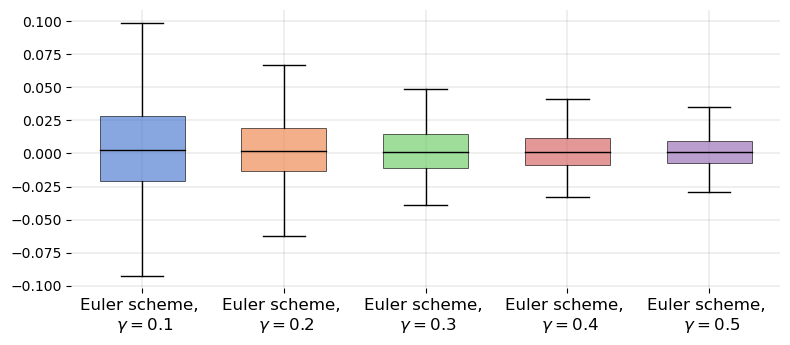

In [502]:
data = [res_new_0[:,0],res_new[:,0],res_new_1[:,0], res_new_2[:,0],res_new_3[:,0]]#,res_new_4[:,1]] 
#data = [res_new_1[:,2], res_new_2[:,2],res_new_3[:,2],res_new_4[:,2]] 
boxplot_ind(data, title, labels_vanilla,path="./2d_nonsymmetric_potential_vanilla_gamma_dependence_02_12_v20.pdf")

In [503]:
print(N_test*np.var(res_new_0[:,0]),N_test*np.var(res_new[:,0]),N_test*np.var(res_new_1[:,0]),N_test*np.var(res_new_2[:,0]),N_test*np.var(res_new_3[:,0]))#,N_test*np.var(res_new_4[:,2]))
print(N_test*np.var(res_new_0[:,2]),N_test*np.var(res_new[:,2]),N_test*np.var(res_new_1[:,2]),N_test*np.var(res_new_2[:,2]),N_test*np.var(res_new_3[:,2]))#,N_test*np.var(res_new_4[:,2]))

8.829761076302749 4.2843465239478 2.764733109614309 1.9915305880106637 1.5158935824810935
0.14656704174839508 0.0929445762979533 0.0724639707408133 0.061741274590027595 0.05670135025348541


In [504]:
print(N_test*np.var(res_new_0[:,2]),N_test*np.var(res_new[:,2]),N_test*np.var(res_new_1[:,2]),N_test*np.var(res_new_2[:,2]),N_test*np.var(res_new_3[:,2]))#,N_test*np.var(res_new_4[:,2]))

0.14656704174839508 0.0929445762979533 0.0724639707408133 0.061741274590027595 0.05670135025348541


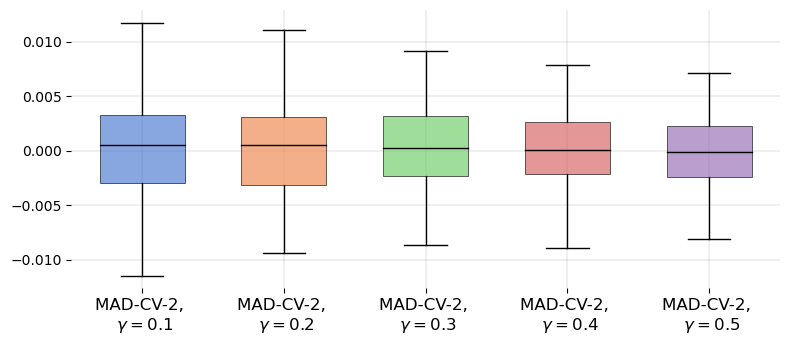

In [505]:
data = [res_new_0[:,2],res_new[:,2],res_new_1[:,2], res_new_2[:,2],res_new_3[:,2]]#,res_new_4[:,2]] 
#data = [res_new_1[:,2], res_new_2[:,2],res_new_3[:,2],res_new_4[:,2]] 
boxplot_ind(data, title, labels,path="./2d_nonsymmetric_potential_2ndorder_gamma_dependence_02_12_v20.pdf")